In [1]:
#头文件
import os
import numpy as np
import pandas as pd
import math
from pandas import DataFrame
from xml.etree import ElementTree as ET
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D
from keras.layers import *
from datetime import date
from keras.models import *
import tensorflow as tf 

Using TensorFlow backend.


In [2]:
#释放gpu
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
os.environ['KERAS_BACKEND']='tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']="0"
config=tf.compat.v1.ConfigProto() 
config.gpu_options.visible_device_list = '0' 
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess=tf.compat.v1.Session(config=config)

In [4]:
#读取数据
dataset=[]
def data_load():
    path='./traffic-matrices'
    FileList = os.listdir(path)
    for files in FileList:
        oldDirPath = path+'/'+files
        per=ET.parse(oldDirPath)
        p=per.findall('./IntraTM/src')
        matrix=np.zeros((23,23))
        for child in p:
            src=child.attrib['id']
            c=child.findall('dst')
            for i in c:
                dst=i.attrib['id']
                matrix[int(src)-1][int(dst)-1]=i.text
        dataset.append(matrix)
    datasets = np.array(dataset)
    return datasets
datasets = data_load()
datasets.shape

(10773, 23, 23)

In [5]:
#二维流量矩阵转一维
data = []
for i in range(len(datasets)):
    arr = []
    for row in datasets[i]:
        arr.extend(row)
    data.append(arr)
data = np.array(data)
data = data[:,40]

In [6]:
#划分训练集和验证集
time_stamp = 120
train = data[6000:10600+time_stamp].reshape(-1,1)
valid = data[10600-time_stamp:-3].reshape(-1,1)
#归一化
scaler1 = MinMaxScaler(feature_range=(0, 1)) 
#训练集
scaled_data = scaler1.fit_transform(train)
x_train, y_train = [], []
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i])
x_train,y_train= np.array(x_train),np.array(y_train)
y_train = y_train.reshape(-1,1)
#验证集
scaled_data2 = scaler1.transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data2[i - time_stamp:i])
    y_valid.append(scaled_data2[i])
x_valid,y_valid = np.array(x_valid),np.array(y_valid)  
y_valid = y_valid.reshape(-1,1)
print(train.shape,x_train.shape,y_train.shape)

(4720, 1) (4600, 120, 1) (4600, 1)


In [7]:
# 超参数
epochs = 100
batch_size = 64
inputs = Input(shape=(time_stamp, 1))
conv = Conv1D(filters=128,kernel_size=2,activation = 'relu',padding='same',input_shape=(time_stamp,1))(inputs)
pool = MaxPooling1D(pool_size=2,padding='valid')(conv)
conv2 = Conv1D(filters=128,kernel_size=2,activation = 'relu',padding='same')(pool)
pool2= MaxPooling1D(pool_size=2,padding='valid')(conv2)
flatten = Flatten()(pool2)
dense = Dense(128)(flatten)
re = RepeatVector(1)(dense)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
lstm_out = LSTM(128,return_sequences=True)(re)
drop2 = Dropout(0.5)(lstm_out)
lstm_out2 = LSTM(128)(drop2)
attention_probs = Dense(128)(lstm_out2)
#attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
attention_mul =Multiply()([lstm_out2, attention_probs])
output = Dense(1)(attention_mul)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam')
work = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 validation_data=(x_valid, y_valid), verbose=1)

Train on 4600 samples, validate on 170 samples
Epoch 1/100
4600/4600 [==============================] - 4s 915us/step - loss: 0.0251 - val_loss: 0.0036
Epoch 2/100
4600/4600 [==============================] - 1s 285us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 3/100
4600/4600 [==============================] - 1s 290us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 4/100
4600/4600 [==============================] - 1s 296us/step - loss: 0.0015 - val_loss: 9.1351e-04
Epoch 5/100
4600/4600 [==============================] - 1s 289us/step - loss: 0.0012 - val_loss: 6.6596e-04
Epoch 6/100
4600/4600 [==============================] - 1s 302us/step - loss: 0.0012 - val_loss: 6.0775e-04
Epoch 7/100
4600/4600 [==============================] - 2s 356us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
4600/4600 [==============================] - 1s 326us/step - loss: 0.0011 - val_loss: 7.3542e-04
Epoch 9/100
4600/4600 [==============================] - 1s 296us/step - loss: 0.0010 - val_loss:

4600/4600 [==============================] - 3s 607us/step - loss: 4.3773e-04 - val_loss: 4.3991e-04
Epoch 73/100
4600/4600 [==============================] - 1s 314us/step - loss: 4.4866e-04 - val_loss: 5.5185e-04
Epoch 74/100
4600/4600 [==============================] - 1s 314us/step - loss: 4.2596e-04 - val_loss: 4.6349e-04
Epoch 75/100
4600/4600 [==============================] - 2s 426us/step - loss: 4.5024e-04 - val_loss: 5.0052e-04
Epoch 76/100
4600/4600 [==============================] - 3s 666us/step - loss: 4.3280e-04 - val_loss: 5.0022e-04
Epoch 77/100
4600/4600 [==============================] - 1s 318us/step - loss: 4.6018e-04 - val_loss: 6.2826e-04
Epoch 78/100
4600/4600 [==============================] - 1s 323us/step - loss: 4.5279e-04 - val_loss: 4.9455e-04
Epoch 79/100
4600/4600 [==============================] - 2s 532us/step - loss: 4.4505e-04 - val_loss: 5.1535e-04
Epoch 80/100
4600/4600 [==============================] - 3s 662us/step - loss: 4.4590e-04 - val_loss

In [8]:
#预测值
y = model.predict(x_valid)
# 反归一化
predict = scaler1.inverse_transform(y)
true = scaler1.inverse_transform(y_valid)
#RMSE
rmse= np.sqrt(np.mean(np.power((true - predict), 2)))
print(rmse)
#MAPE
mape = np.mean(np.abs((true - predict) / true)) * 100
print(mape)

3611.4593847105816
4.627400482127886


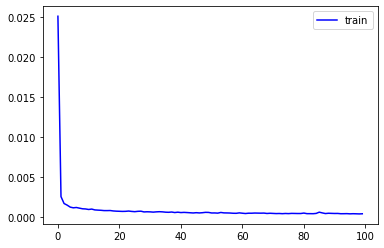

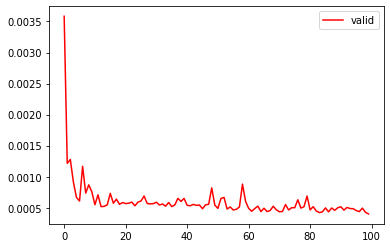

In [9]:
plt.plot(work.history['loss'], label='train', color='b')
plt.legend()
plt.show()
plt.plot(work.history['val_loss'], label='valid',color='r')
plt.legend()
plt.show()

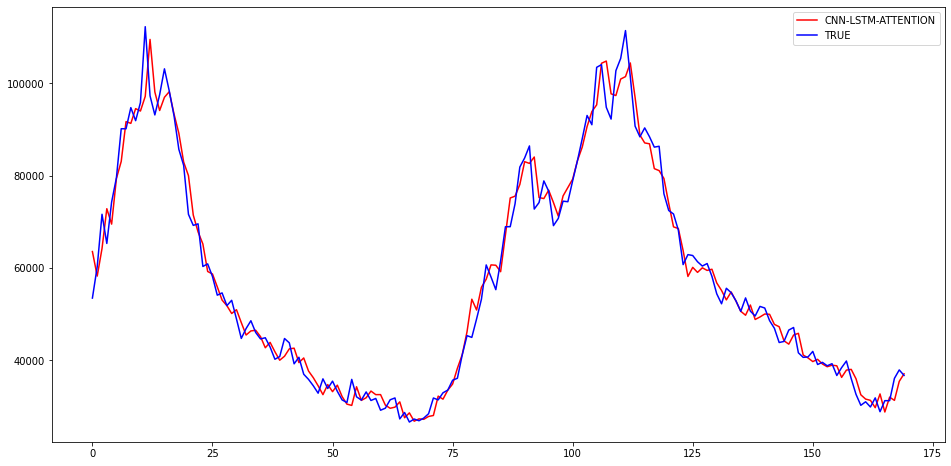

In [10]:
plt.figure(figsize=(16, 8))
predict = predict.reshape(1,-1)[0]
valid = valid.reshape(1,-1)[0]
plt.plot(np.arange(len(predict)),predict,label='CNN-LSTM-ATTENTION',color='r')
plt.plot(np.arange(len(true)),true,label='TRUE',color='b')
plt.legend()
plt.show()

(4600, 120, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 120, 128)     384         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 60, 128)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 128)      32896       max_pooling1d_1[0][0]            
_____________________________________________________________________________

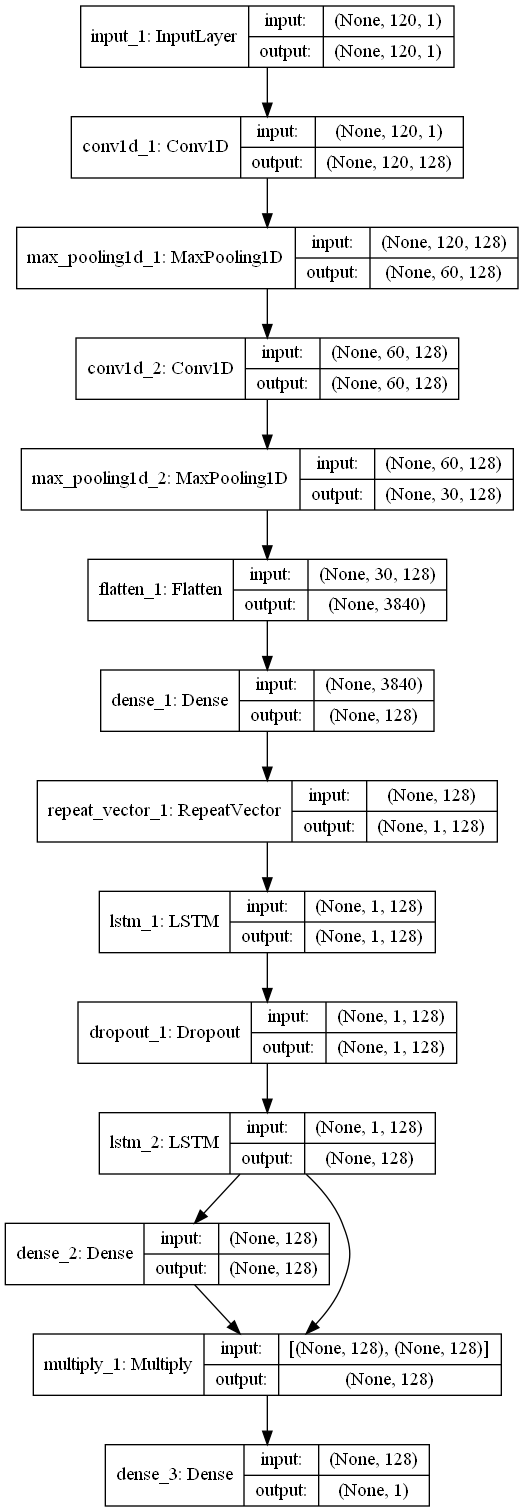

In [11]:
print(x_train.shape)
import keras
# 查看模型层及参数
model.summary()
# 将模型结构保存为图片
keras.utils.plot_model(model,to_file='cnn-lstm-attention.png', show_shapes=True)
